In [ ]:
pip install numpy pandas matplotlib scikit-learn tensorflow yfinance


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import yfinance as yf



In [ ]:
# Load the stock data
stock_data = yf.download('AAPL', start='2015-01-01', end='2024-01-01')

# Show the stock data
stock_data.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373960,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687304,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689531,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021715,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944681,237458000


In [ ]:
# Extract the 'Close' column
data = stock_data[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into training and testing sets
training_data_len = int(np.ceil(len(data) * 0.8))

# Create training dataset
train_data = scaled_data[0:int(training_data_len), :]

# Split the data into x_train and y_train datasets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [ ]:
# Build the LSTM model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))

# Add Dense layers
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model
model.fit(x_train, y_train, batch_size=64, epochs=10)


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0303
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 9.0987e-04
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 3.9723e-04
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 3.6484e-04
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 2.9876e-04
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 3.0659e-04
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 2.9889e-04
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 3.0481e-04
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 3.1180e-04
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 3.4303e-04


In [ ]:
# Create the test dataset
test_data = scaled_data[training_data_len - 60:, :]

# Create the x_test and y_test datasets
x_test = []
y_test = data[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert to numpy arrays
x_test = np.array(x_test)

# Reshape the data for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [ ]:
# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step


<ipython-input-13-5e391b1f1d6d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


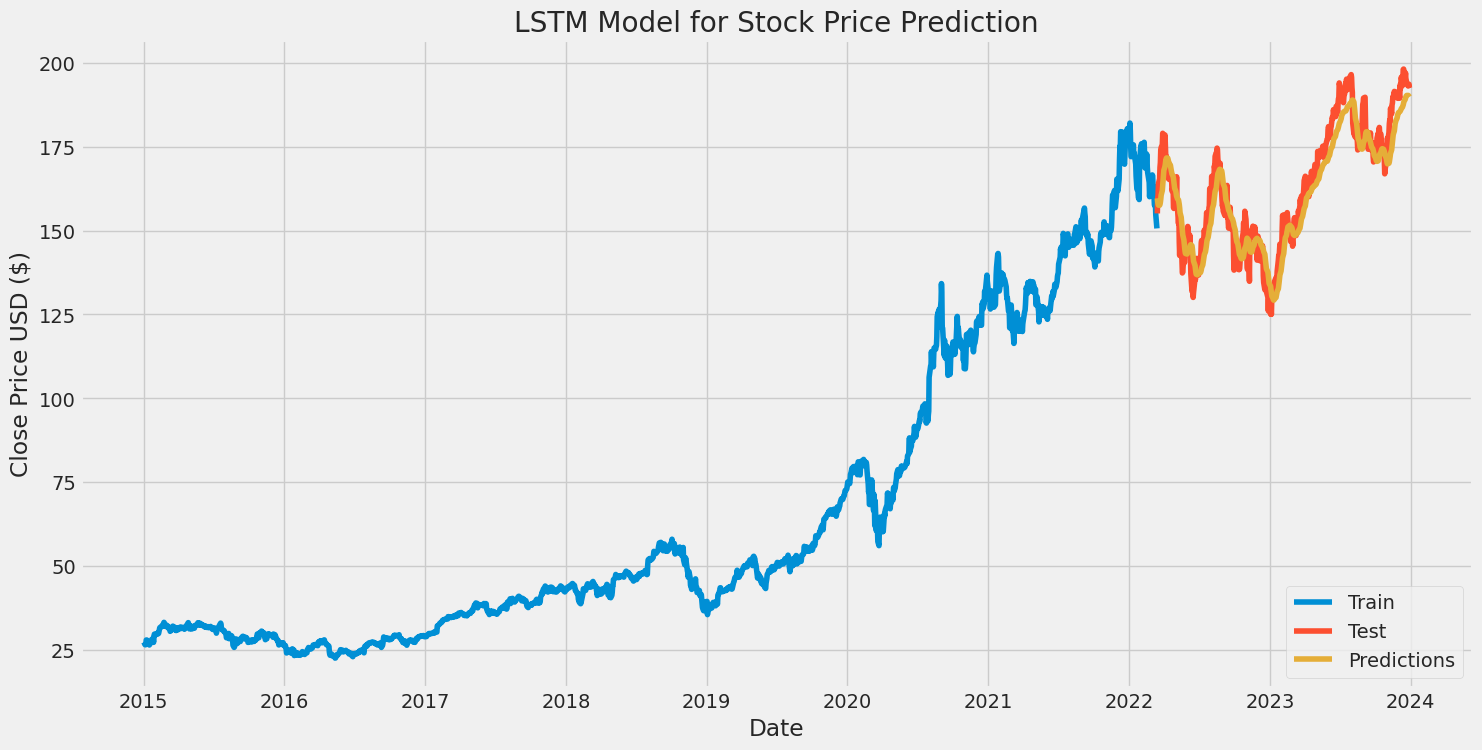

In [ ]:
# Plot the data
train = stock_data[:training_data_len]
valid = stock_data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16, 8))
plt.title('LSTM Model for Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()


In [ ]:
# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 6.4756477958792615
